# Machine learning regression with applications to damage homogenization

In this tuorial, regression function in form of machinbe learning models are fit to noisy data sets, either created artificially or resulting from finite element simultions.

Author: Alexander Hartmaier</br>
Institution: ICAMS, Ruhr-Universität Bochum, Germany</br>
Date: March 2021

This work is licensed under a Creative 
Commons Attribution-NonCommercial-ShareAlike 4.0 International License
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">(CC-BY-NC-SA)</a>
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
<img alt="Creative Commons License" style="border-width:0;max-heigt:9px;height:100%;" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>

## 1. Machine learning regression of noisy sine-function

Artificial data is created by adding some noise to the trigonmetrix sine function. The following machine learning method are trained on this data:

* Support Vector Regression (SVR)
* Decision Tree Regression (DTR)
* Random Forest Regression (RFR)

### Tasks:
Change the so-called meta parameters of the machine learning methods that control their training behavior and observe the resulting changes in the standard deviations. Can you find optimal parameters?
1. Modify the maximum depth of the decision trees for DTR and RFR
2. Modify the values of "C" and "gamma" for the SVR
3. Change the number of trees ("n_estomators") in the interval [1,...,1000] 

Example adapted from the scikit-learn.platform, see https://scikit-learn.org/stable/

Standard deviations
SVR:  0.04839956560299732
DTR:  0.1635059408688802
RFR:  0.20709555034435045


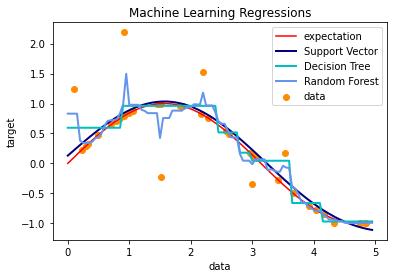

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn.svm import SVR
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor


# #############################################################################
# Generate sample data
N = 40
np.random.seed(42)
X = np.sort(5 * np.random.rand(N, 1), axis=0)
y = np.sin(X).ravel()

# #############################################################################
# Generate test data
Xtest = 5 * np.arange(0,1,0.01)
Xtest1 = Xtest.reshape(100,1)

# #############################################################################
# Add noise to targets
# case 1: 'Outliers'
y[::5] += 3 * (0.5 - np.random.rand(8))

# case 2: standard errors 
#y += 0.5 * np.random.randn(N)


# #############################################################################
# Train Machine Learning Regressors
# #############################################################################
# Support Vector Regression
svr_rbf = SVR(kernel='rbf', C=10, gamma=0.1)
svr_rbf.fit(X, y)
y_rbf = svr_rbf.predict(Xtest1)

# Decision Tree Regression
regr_dtr = tree.DecisionTreeRegressor(max_depth=3)
regr_dtr.fit(X, y)
y_dtr = regr_dtr.predict(Xtest1)

# Random Forest Regression
regr_rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=2)
regr_rf.fit(X, y)
y_rf = regr_rf.predict(Xtest1)

# #############################################################################
# Analyze and visualize results
# #############################################################################
# Calculate errors
y_expect = np.sin(Xtest)
chi2_svr = np.std(y_rbf - y_expect)
chi2_dtr = np.std(y_dtr - y_expect)
chi2_rf = np.std(y_rf - y_expect)
print('Standard deviations')
print('SVR: ',chi2_svr)
print('DTR: ',chi2_dtr)
print('RFR: ',chi2_rf)

# Look at the results
lw = 2
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(Xtest, y_expect, color='red', label='expectation')
plt.plot(Xtest, y_rbf, color='navy', lw=lw, label='Support Vector')
plt.plot(Xtest, y_dtr, color='c', lw=lw, label='Decision Tree')
plt.plot(Xtest, y_rf, color='cornflowerblue', lw=lw, label='Random Forest')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Machine Learning Regressions')
plt.legend()
plt.show()


## 2. Machine learning regression for evolution of damage value 

Data of the damage evolution in a simple ploycrystalline microstructure has been generated by crystal plasticiy finite element simulations. Random Forest Regressor (RFR) is trained by this data and the results are analyzed.


In [2]:
# Loading data, training and testing RFR
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

print('\n ----------- Random Forest Regression ---------- \n')

#loading data with pandas'
DataNames = ['D[-]','D_dot[1/s]','p[-]','p_dot[1/s]','Mises[MPa]','Hydro[MPa]','teq[-]','eeq[-]','V[mm^3]','Sig_tri[-]','LoadState']
AllData = totdf = pd.read_csv('data/merged_data.csv',header=1,names=DataNames)

#chosing wich paramters to use as input (features) for training
InNames = ['D[-]','p_dot[1/s]','Mises[MPa]','Hydro[MPa]']
input_data = AllData[InNames]
output_data = np.absolute(AllData['D_dot[1/s]'])
loading_states = AllData['LoadState']

#Preprocessing data
rndstate = 40
#Splitting into training and test set
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, random_state=rndstate)
#splitting loading state names with the same random state!
y_train_sim, y_test_sim = train_test_split(loading_states, random_state=rndstate)

#define random forest regressor parameters
forest = ensemble.RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                                        max_features='auto', max_leaf_nodes=None,
                                        min_impurity_decrease=0.0, min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
                                        oob_score=False, random_state=rndstate, verbose=0, warm_start=False)

print('estimator parameters:')
print(forest,'\n')

#Cross-Validation
print('--Cross-validation--\n')
kfold=KFold(n_splits=3, shuffle=True, random_state=rndstate)
scores = cross_val_score(forest,X_train,y_train,cv=kfold)*100.0
print('Cross-validation scores [%]: {}\n'.format(scores))
print('Average cross-validation score: {} %\n\n'.format(scores.mean()))

#fit training data
print('training model\n')
forest.fit(X_train, y_train)

#compute traning and test scores
train_score = 100*forest.score(X_train, y_train)
test_score = 100*forest.score(X_test, y_test)
print("Training set score: {} %".format(train_score))
print("Test set score: {} %".format(test_score))


 ----------- Random Forest Regression ---------- 

estimator parameters:
RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=40) 

--Cross-validation--

Cross-validation scores [%]: [-2266.73495802    22.30229155    36.07966056]

Average cross-validation score: -736.1176686354232 %


training model

Training set score: 92.09010552329194 %
Test set score: 99.42784018170796 %


## 2.2. Calculate results of Chaboche damage model for comparison


Definition of damage rate:
\begin{equation} \dot{D} = \left( \frac{Y}{S} \right)^s \, \dot{p} \end{equation}
with
\begin{equation} 
Y = \frac{\sigma_{eq}^2}{2 E \left(1-D\right)^2} 
\left[ \frac{2}{3}(1+\nu) +3 (1-2\nu) \left( \frac{\sigma_{hyd}^2}{\sigma_{eq}^2} \right)^2  \right]
\end{equation}

(see for example J.L. Chaboche. Continuum Damage Mechanics: Part II—Damage Growth, Crack Initiation, and Crack Growth, J. Appl. Mech 55 (1988) 65-72  doi:10.1115/1.3173662 )


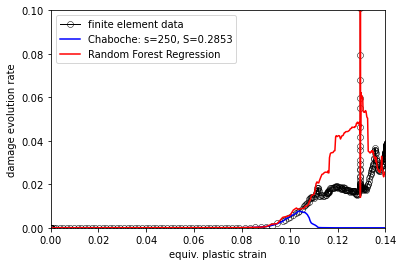

In [22]:
#Read data for uniaxial loading state as basis for Chaboche damage model
ChaData = totdf = pd.read_csv('data/examples_Tx_forAnalytical_1.txt',sep='\t',header=1,names=DataNames)

#Define aterial parameters according to finite element model of damage evolution within the microstructure
E = 228960.0 #Youngs modulus [MPa] 
nu = 0.27 #Poisson ratio

#input data
sigmaEq = ChaData['Mises[MPa]'] #[MPa]
sigmaHyd = ChaData['Hydro[MPa]'] #[MPa]
peeq = ChaData['p[-]']
p_dot = abs(ChaData['p_dot[1/s]']) #[1/s]
Damage = ChaData['D[-]'] #[-]
DRate_num = ChaData['D_dot[1/s]']

# calculate damage energy release rate
Y1 = np.divide( np.power(sigmaEq,2), (2.0*E*np.power(np.subtract(1,Damage),2)) )
Y2 = np.add( 2.0/3.0*(1.0+nu), np.multiply(3.0*(1.0-2.0*nu), np.power( np.divide(sigmaHyd,sigmaEq) ,2) ) )
Y = np.multiply(Y1,Y2)

#Damage rate according to Chaboche in [1/s]
s = 250
S = 0.2853 # max(Y) = 0.282752234031715   #S=0.2853, s=250
DRate = np.multiply( np.power(np.divide(Y,S),s), p_dot)

#Damage rate accoring to RFR
pred_data=ChaData[InNames]
DRate_RFR = forest.predict(pred_data)

#plot results of RFR and Chaboche model
plt.plot(peeq, DRate_num,'.-k',linewidth=1., markersize=12, markeredgewidth=0.5,markerfacecolor='none', label=r'finite element data')
plt.plot(peeq, DRate,'-b',linewidth=1.5, label=r'Chaboche: s=%s, S=%s'%(s,S))
plt.plot(peeq,DRate_RFR,'-r',linewidth=1.5, label=r'Random Forest Regression')
plt.xlabel('equiv. plastic strain')
plt.ylabel('damage evolution rate')
plt.legend(loc='upper left')
plt.axis([0, 0.14, 0, 0.1])
plt.show()

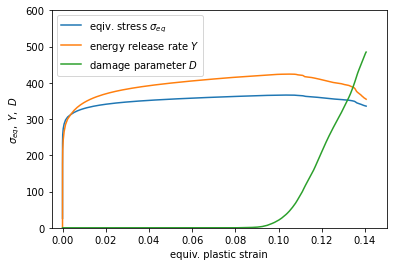

In [21]:
#Plot stress strain curve with damage energy release rate and damage
plt.plot(peeq,sigmaEq, label='eqiv. stress $\sigma_{eq}$')
plt.plot(peeq,Y*1500, label='energy release rate $Y$')
plt.plot(peeq,Damage*5.e4, label='damage parameter $D$')
plt.ylabel('$\sigma_{eq},\,\, Y,\,\, D$')
plt.xlabel('equiv. plastic strain')
plt.legend(loc='upper left')
plt.axis([-0.005, 0.15, 0, 600])
plt.show()